# NLP Chatbot using LSTM Algorithm

**Chatbot** merupakan salah satu project aplikasi dari NLP (Natural Language Processing) yang digunakan **untuk percakapan dengan pengguna melalui teks dan ucapan**. Pada praktik ini kita akan membuat sebuah chat otomatis atau chatbot tentang program Kampus Merdeka dari Kementerian Pendidikan Kebudayaan Riset dan Teknologi (KEMENDIKBUDRISTEK).

Dalam tahapan Chatbot ini ada tahapan yang harus kita perhatikan yaitu,

1. Import Library
2. Load & Preparing Dataset
3. Preprocessing Data
4. Input Length, Output Length, and Vocabulary
5. Long Short Term Memory Model
6. Evaluation Model Analysis
7. Testing Chatbot
8. Save The Model

Dalam proyek ini, kita akan membuat chatbot tentang program Kampus Merdeka!

# Import Library

## Install Package
Instalasi package sangat diperlukan ketika kita membutuhkan suatu fitur atau library yang akan kita gunakan. Pada proyek Chatbot yang akan dibuat kali ini membutuhkan package library yaitu **Speech Recognition** dan **Google Text To Speech** yang harus di install.

In [2]:
# INSTALL PACKAGE SPEECH RECOGNITION & GOOGLE TEXT TO SPEECH
!pip -q install gtts speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 27.5 MB/s eta 0:00:00


*Notes : Penginstalan dengan tanda -q maksudnya adalah mode quiet atau diam sehingga tidak mengeluarkan output saat eksekusi*

## Import Library & Package
Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang  digunakan yaitu **NumPy** untuk komputasi matematika, **Matplotlib** untuk visualisasi model data, Natural Language Toolkit atau **NLTK** untuk pengolahan teks, **Pandas** untuk membaca data, serta **Tensorflow** untuk model pada data menggunakan algoritma LSTM (Long Short Term Memory).

In [3]:
# IMPORT LIBRARY
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, Dense, GlobalMaxPool1D

## Download NLTK Package

In [4]:
# NLTK PACKAGE
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Load & Preparing Dataset

## Download Dataset

Sebelum melakukan pemrosesan data, kita harus mendownload dataset yang sudah tersedia pada link github. Disini kita memerlukan library dari **urllib** untuk request ke github repository.

In [5]:
# DOWNLOAD DATASET FROM GITHUB
from urllib import request
url = "https://raw.githubusercontent.com/fendy07/chatbot-AI/master/kampus_merdeka.json"
request.urlretrieve(url, "kampus_merdeka.json")

('kampus_merdeka.json', <http.client.HTTPMessage at 0x7ae732579450>)

## Connect to Drive
Setelah mendownload dataset dari github, selanjutnya simpan ke dalam google drive menggunakan library dari colab.

In [6]:
# CONNECT TO GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setelah dirunning maka ada notifikasi untuk **Permit this notebook to your access Google Drive** lalu ikuti langkah untuk mengizinkan data dan akan diproses ke dalam login akun google kita.

## Preparing Data
Tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot.

Data json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti tag, pattern, context, dan response. Data yang dipakai dalam proyek ini menggunakan dataset manual yang diciptakan oleh **Student Kampus Merdeka Batch 2 tentang Chatbot Sistem Rekomendasi Kampus Merdeka**

In [7]:
# Importing the dataset
with open('/content/kampus_merdeka.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!', ','] # Mengabaikan karakter spesial

# melihat semua isi data pada file .json
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    # menambahkan patterns atau pertanyaan ke dalam list
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # menambahkan class ke dalam list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns": inputs, "tags": tags})

### Show Data Head
Menampilkan data awal dari baris 1 sampai 5

In [8]:
data.head()

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


### Show Data Describe

Menampilkan descripsi dari data seperti total data, jumlah data unik, isi data paling atas dan jumlah frekuensi

In [9]:
data.describe()

,patterns,tags
count,80,80
unique,79,40
top,Apa saja persyaratan IISMA?,greeting
freq,2,15


# Preprocessing Data
Setelah meload data dan mengubah data **json** menjadi **dataframe**. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan tahapan berikut :

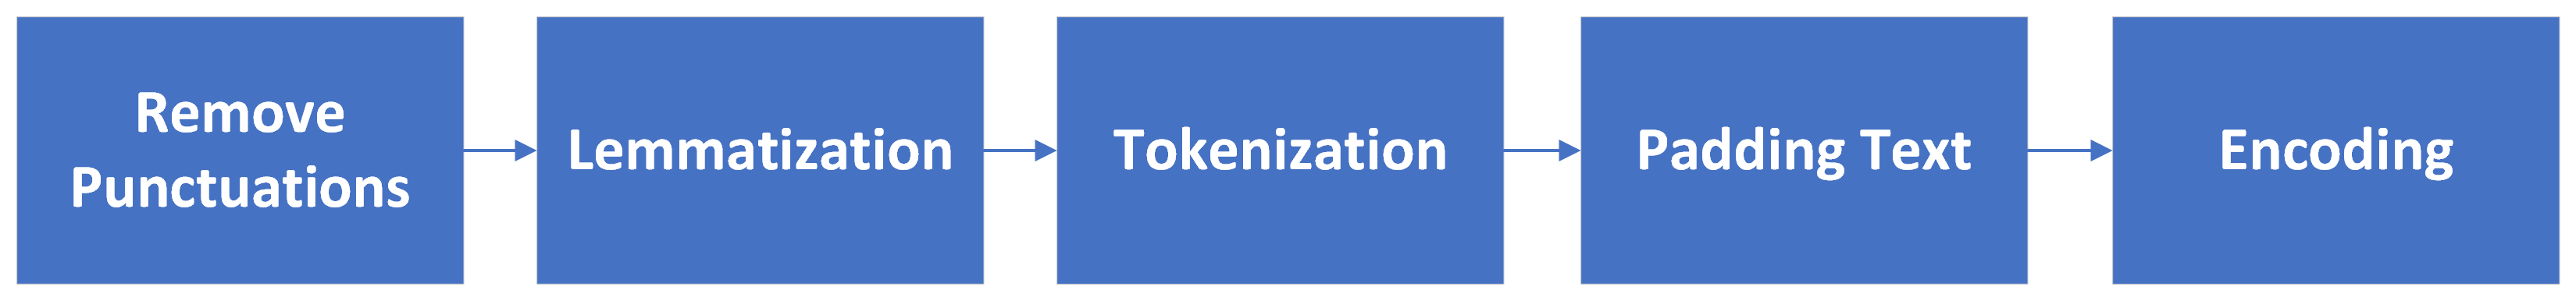

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

## Remove Punctuations
Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti special character yaitu **'!' (tanda seru) ',' (tanda koma) '.' (tanda titik sebagai berhenti) '?' (tanda tanya) dan tanda baca yang lain.** Tahapan ini gunanya untuk menghilangkan karakter-karakter yang tidak diperlukan sehingga mempermudah proses selanjutnya.

In [10]:
# Remove Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## Lemmatization
Tahapan yang kedua yaitu proses *lemmatization*. Pada proses ini dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai **lemma**.

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar)

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu Menggunakan dimana **meng- + guna** (kata dasar yang berawalan vokal g) **+ kan** (sebagai akhiran) diubah menjadi kata dasar yaitu **'guna'**.


Proses ini dimana menghilangkan Prefiks pada imbuhan **(Meng-)** dan Suffiks pada **(-kan)**.

In [11]:
# Lemmatization (Lematisasi)
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

77 unique lemmatized words ['afternoon', 'apa', 'apabila', 'bagaimana', 'bai', 'banyak', 'bersertifikat', 'bro', 'buat', 'bumn', 'bye', 'byee', 'cara', 'dadah', 'dah', 'dalam', 'dan', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'iisma', 'independen', 'itu', 'jumpa', 'kadek', 'kadekbot', 'kampus', 'kamu', 'kasih', 'kawan', 'kemendikbud', 'kemensos', 'magang', 'mahasiswa', 'makasih', 'malam', 'manfaat', 'mendaftar', 'mengajar', 'mengikuti', 'merdeka', 'mitra', 'morning', 'muda', 'pagi', 'pejuang', 'pelaksanaan', 'pembuatmu', 'penciptamu', 'periode', 'persyaratan', 'pertukaran', 'pmmb', 'program', 'saja', 'sampai', 'see', 'selamat', 'si', 'siang', 'siapa', 'sih', 'sore', 'studi', 'tergabung', 'terima', 'thank', 'thanks', 'tinggal', 'tujuan', 'universitas', 'yang', 'you']


In [12]:
# Mengkategorikan kelas
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

40 classes ['goodbye', 'greeting', 'kadekbot', 'manfaat_IISMA', 'manfaat_PMMB', 'manfaat_kampus_mengajar', 'manfaat_magang', 'manfaat_pejuang_muda', 'manfaat_pertukaran_mahasiswa', 'manfaat_studi_independen', 'mitra_IISMA', 'mitra_PMMB', 'mitra_magang', 'mitra_studi_independen', 'pencipta_kadekbot', 'penjelasan_IISMA', 'penjelasan_PMMB', 'penjelasan_kampus_mengajar', 'penjelasan_kampus_merdeka', 'penjelasan_magang', 'penjelasan_pejuang_muda', 'penjelasan_pertukaran_mahasiswa', 'penjelasan_studi_independen', 'periode_dan_pendaftaran_IISMA', 'periode_dan_pendaftaran_PMMB', 'periode_dan_pendaftaran_kampus_mengajar', 'periode_dan_pendaftaran_magang', 'periode_dan_pendaftaran_pejuang_muda', 'periode_dan_pendaftaran_pertukaran_mahasiswa', 'periode_dan_pendaftaran_studi_independen', 'persyaratan_IISMA', 'persyaratan_kampus_mengajar', 'persyaratan_kampus_merdeka', 'persyaratan_magang', 'persyaratan_pejuang_muda', 'persyaratan_pertukaran_mahasiswa', 'persyaratan_studi_independen', 'program_kamp

In [13]:
# Menampilkan jumlah documents (kombinasi antara data 'tags' dan data 'patterns' di dalam data json)
print(len(documents), "documents")

438 documents


## Tokenization (Tokenisasi)
Tahap ketiga yaitu *Tokenization*, dalam proses ini akan dilakukan suatu proses untuk memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan **'Token'** dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: Aku Pergi Ke Makassar -> 'Aku' 'Pergi' 'Ke' 'Makassar'

In [14]:
# Memecah isi data 'patterns' menjadi token dan menampilkan urutan indexnya
tokenizer = Tokenizer(num_words=80)
tokenizer.fit_on_texts(data['patterns'])
tokenizer.word_index

{'apa': 1,
 'saja': 2,
 'program': 3,
 'kampus': 4,
 'merdeka': 5,
 'itu': 6,
 'persyaratan': 7,
 'mengikuti': 8,
 'iisma': 9,
 'bagaimana': 10,
 'periode': 11,
 'pelaksanaan': 12,
 'dan': 13,
 'cara': 14,
 'mendaftar': 15,
 'manfaat': 16,
 'apabila': 17,
 'studi': 18,
 'independen': 19,
 'magang': 20,
 'yang': 21,
 'mengajar': 22,
 'pertukaran': 23,
 'mahasiswa': 24,
 'pejuang': 25,
 'muda': 26,
 'pmmb': 27,
 'bersertifikat': 28,
 'siapa': 29,
 'tergabung': 30,
 'dalam': 31,
 'kadekbot': 32,
 'kadek': 33,
 'bye': 34,
 'you': 35,
 'terima': 36,
 'kasih': 37,
 'mitra': 38,
 'universitas': 39,
 'hallo': 40,
 'hai': 41,
 'halo': 42,
 'hei': 43,
 'hi': 44,
 'hy': 45,
 'pagi': 46,
 'morning': 47,
 'siang': 48,
 'afternoon': 49,
 'sore': 50,
 'malam': 51,
 'bro': 52,
 'sis': 53,
 'kawan': 54,
 'pembuatmu': 55,
 'buat': 56,
 'kamu': 57,
 'sih': 58,
 'penciptamu': 59,
 'dah': 60,
 'dadah': 61,
 'byee': 62,
 'good': 63,
 'selamat': 64,
 'tinggal': 65,
 'sampai': 66,
 'jumpa': 67,
 'bai': 68,
 '

In [15]:
# Merubah data token menjadi sequence atau angka
train = tokenizer.texts_to_sequences(data['patterns'])

In [16]:
train

[[40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [1, 6, 32],
 [29, 32],
 [29, 55],
 [33, 21, 56, 57, 29, 58],
 [29, 59, 33],
 [60],
 [61],
 [34],
 [62],
 [63, 34],
 [64, 65],
 [66, 67],
 [68],
 [69, 35],
 [70],
 [71, 35],
 [36, 37],
 [72],
 [36, 37, 73],
 [1, 6, 4, 5],
 [1, 74, 4, 5],
 [1, 7, 8, 4, 5],
 [1, 2, 3, 4, 5],
 [3, 4, 5, 75],
 [3, 4, 5, 76],
 [3, 4, 5, 77],
 [18, 19],
 [20],
 [4, 22],
 [9],
 [23, 24, 5],
 [25, 26],
 [27],
 [1, 6, 18, 19],
 [1, 2, 7, 18, 19],
 [10, 11, 12, 13, 14, 15, 3, 18, 19],
 [1, 2, 16, 17, 8, 18, 19],
 [1, 2, 38, 21, 30, 31, 18, 19],
 [1, 6, 20, 28],
 [1, 2, 7, 20, 28],
 [10, 11, 12, 13, 14, 15, 3, 20, 28],
 [1, 2, 16, 17, 8, 20, 28],
 [1, 2, 38, 21, 30, 31, 20, 28],
 [1, 6, 4, 22],
 [1, 2, 7, 4, 22],
 [10, 11, 12, 13, 14, 15, 3, 4, 22],
 [1, 2, 16, 17, 8, 4, 22],
 [1, 6, 9],
 [1, 2, 7, 9],
 [10, 11, 12, 13, 14, 15, 3, 9],
 [1, 2, 16, 17, 8, 9],
 [1, 2, 39, 21, 30, 31, 3, 9],
 [1, 6, 23, 24, 5],
 [

In [17]:
data['patterns']

0                                                 hallo
1                                                   hai
2                                                  halo
3                                                   hei
4                                                    hi
                            ...                        
75                                         apa itu pmmb
76                           apa saja persyaratan iisma
77    bagaimana periode pelaksanaan dan cara mendaft...
78              apa saja manfaat apabila mengikuti pmmb
79    apa saja universitas yang tergabung dalam prog...
Name: patterns, Length: 80, dtype: object

hallo -> 40

hai -> 41

Dari contoh data diatas dapat dilihat, data pertama memiliki kata **'hallo'** dan ketika dijadikan sebuah sequence menjadi angka **40** dimana angka 40 merupakan urutan index setelah proses tokenisasi

## Padding Text
Tahap yang keempat yaitu *Padding*. Padding adalah suatu proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence.

Padding juga adalah proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar.

In [18]:
# Melakukan proses padding pada data
x_train = pad_sequences(train)
# Menampilkan hasil padding
print(x_train)

[[ 0  0  0  0  0  0  0  0  0 40]
 [ 0  0  0  0  0  0  0  0  0 41]
 [ 0  0  0  0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0  0  0  0 43]
 [ 0  0  0  0  0  0  0  0  0 44]
 [ 0  0  0  0  0  0  0  0  0 45]
 [ 0  0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0  0  0 47]
 [ 0  0  0  0  0  0  0  0  0 48]
 [ 0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 51]
 [ 0  0  0  0  0  0  0  0  0 52]
 [ 0  0  0  0  0  0  0  0  0 53]
 [ 0  0  0  0  0  0  0  0  0 54]
 [ 0  0  0  0  0  0  0  1  6 32]
 [ 0  0  0  0  0  0  0  0 29 32]
 [ 0  0  0  0  0  0  0  0 29 55]
 [ 0  0  0  0 33 21 56 57 29 58]
 [ 0  0  0  0  0  0  0 29 59 33]
 [ 0  0  0  0  0  0  0  0  0 60]
 [ 0  0  0  0  0  0  0  0  0 61]
 [ 0  0  0  0  0  0  0  0  0 34]
 [ 0  0  0  0  0  0  0  0  0 62]
 [ 0  0  0  0  0  0  0  0 63 34]
 [ 0  0  0  0  0  0  0  0 64 65]
 [ 0  0  0  0  0  0  0  0 66 67]
 [ 0  0  0  0  0  0  0  0  0 68]
 [ 0  0  0  0  0  0  0  0 69 35]
 [ 0  0  0  0  0  0  0  0  0 70]
 [ 0  0  0

## Encoding
Tahap terakhir dari praproses data disini ialah *Encoding*. Encoding merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1.

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [19]:
# Melakukan konversi data label tags dengan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2 14 14 14  0  0  0  0
  0  0  0  0  0 38 38 38 38 38 18 39 32 37 37 37 37 37 37 37 37 37 37 37
 22 36 29  9 13 19 33 26  6 12 17 31 25  5 15 30 23  3 10 21 35 28  8 20
 34 27  7 16 30 24  4 11]


# Input Length, Output Length, and Vocabulary
**Input length** dan **output length** adalah bentuk input dan bentuk output dari data train yang akan diproses pada algoritma LSTM yang akan dilatih.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## Input Length

In [20]:
# Melihat hasil input pada data teks
input_shape = x_train.shape[1]
print(input_shape)

10


## Output Length


In [21]:
# Melakukan pemeriksaan pada data output label teks
output_length = le.classes_.shape[0]
print("output length: ", output_length)

output length:  40


## Vocabulary

In [22]:
# Melakukan definisi tiap kalimat dan kata pada data teks
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

number of unique words :  77


## Save Result With Pickle

In [23]:
# Simpan hasil pemrosesan teks dengan menggunakan pickle
pickle.dump(words, open('words.pkl','wb')) # simpan kata
pickle.dump(classes, open('classes.pkl','wb')) # simpan kelas
pickle.dump(le, open('le.pkl','wb')) # simpan label encoder
pickle.dump(tokenizer, open('tokenizers.pkl','wb')) # simpan tokenizer

# **Long Short Term Memory (LSTM) Model**

Tahapan selanjutnya adalah melakukan modelling atau pemodelan untuk Chatbot dengan menggunakan algoritma LSTM (Long Short Term Memory).

**LSTM (Long Short Term Memory)** merupakan algoritma Deep Learning yang populer dan cocok digunakan untuk membuat prediksi dan klasifikasi yang berhubungan dengan waktu dan data teks.

Algoritma ini bisa dikatakan pengembangan atau salah satu jenis dari algoritma RNN (Recurrent Neural Network). Dalam algoritma RNN, output dari langkah terakhir diumpankan kembali sebagai input pada langkah yang sedang aktif. Namun, algoritma RNN memiliki kekurangan yaitu tidak dapat memprediksi kata yang disimpan dalam memori jangka panjang.

Nah, algoritma LSTM dirancang untuk mengatasi kelemahan tersebut, namun tetap mempertahankan kelebihan yang ada pada algoritma RNN dimana RNN mampu memberikan prediksi yang lebih akurat dari informasi terbaru.

Algoritma LSTM pertama kali dikembangkan oleh Hochreiter dan Schmidhuber.  Algoritma ini mampu menyimpan informasi untuk jangka waktu yang lama. Hal ini kemudian dapat digunakan untuk memproses, memprediksi, dan mengklasifikasikan informasi berdasarkan data deret waktu.

Struktur algoritma LSTM terdiri atas neural network dan beberapa blok memori yang berbeda. Blok memori ini disebut sebagai cell.  State dari cell dan hidden state akan diteruskan ke cell berikutnya.

Seperti yang ditunjukkan pada gambar di bawah, bangun berbentuk persegi panjang berwarna biru adalah **ilustrasi cell** pada LSTM.

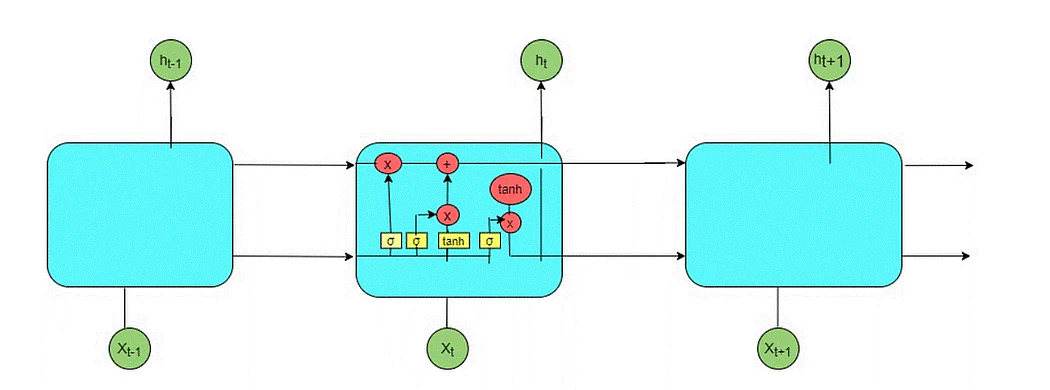

Informasi yang dikumpulkan oleh algoritma LSTM kemudian akan disimpan oleh cell dan manipulasi memori dilakukan oleh komponen yang disebut dengan gate. Ada tiga jenis gate pada algoritma LSTM, di antaranya  Forget gate, Input gate, dan  Output gate. Sumber : [Trivusi](https://www.trivusi.web.id/2022/07/algoritma-lstm.html)

Jaringan syaraf dalam kasus chatbot ini yang terdiri dari lapisan atau *layer* embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan (*layer*) embedding adalah input (masukan) data teks dari lapisan berulang (*recurrent*) dengan layer LSTM gate (Lapisan Gerbang **Long Shot Term Memory)**. Kemudian, output atau keluaran diratakan dan lapisan Dense digunakan dengan fungsi aktivasi **Softmax** yang dimana implementasi chatbot ini memiliki data label lebih dari dua kelas.

Bagian utama dalam pemodelan chatbot ini adalah lapisan embedding yang memberikan nilai vektor yang sesuai untuk setiap kata dalam data teks yang telah dimasukkan.

In [24]:
# Creating the model (Membuat Modelling)
i = Input(shape=(input_shape)) # Layer Input
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x) # Model yang telah disusun dari layer Input sampai layer Output

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

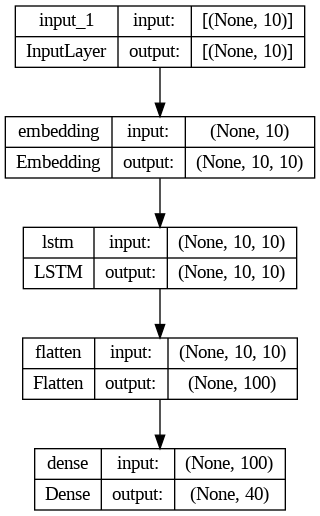

In [25]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
# Menampilkan parameter pada model LSTM
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 10)            780       
                                                                 
 lstm (LSTM)                 (None, 10, 10)            840       
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 40)                4040      
                                                                 
Total params: 5660 (22.11 KB)
Trainable params: 5660 (22.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Training the model (Melatih model data sampai 450 kali)
print('Fitting model..')
train = model.fit(x_train, y_train, epochs=450)

Fitting model..
Epoch 1/450
3/3 [==============================] - 4s 13ms/step - loss: 3.6852 - accuracy: 0.0125
Epoch 2/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6764 - accuracy: 0.1125
Epoch 3/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6677 - accuracy: 0.2250
Epoch 4/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6580 - accuracy: 0.1875
Epoch 5/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6462 - accuracy: 0.1875
Epoch 6/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6342 - accuracy: 0.1875
Epoch 7/450
3/3 [==============================] - 0s 11ms/step - loss: 3.6187 - accuracy: 0.1875
Epoch 8/450
3/3 [==============================] - 0s 12ms/step - loss: 3.5979 - accuracy: 0.1875
Epoch 9/450
3/3 [==============================] - 0s 11ms/step - loss: 3.5777 - accuracy: 0.1875
Epoch 10/450
3/3 [==============================] - 0s 11ms/step - loss: 3.5519 - accuracy: 0.1875
Epo

# Evaluation Model Analysis
Setelah menjalankan pelatihan model dengan algoritma LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model LSTM tersebut.

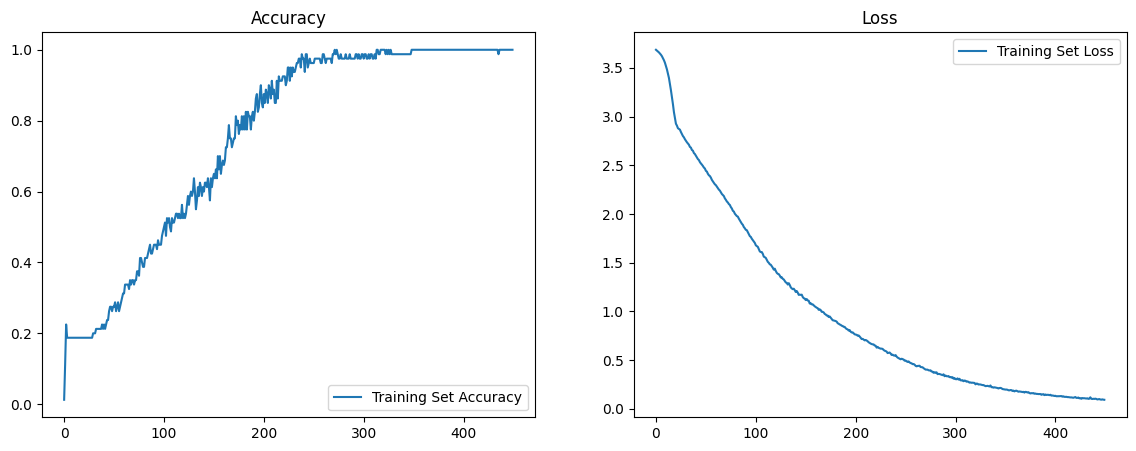

In [28]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Testing Chatbot
Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya.

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [29]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi atau tanda baca dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Melakukan Tokenisasi dan Padding pada data teks
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  # Konversi data teks menjadi array
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil prediksi keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan suara bot
  response_tag = le.inverse_transform([output])[0]
  # Bot akan melakukan random jawaban percakapan dari hasil pertanyaan
  response_ans = random.choice(responses[response_tag])
  print("🤖 KadekBot : ", response_ans)
  # Tambahkan suara bot dengan Google Text to Speech
  tts = gTTS(response_ans, lang='id')
  # Simpan model voice bot ke dalam Google Drive dengan format .wav
  tts.save('KadekBot.wav')
  # Atur waktu jeda sampai 8 detik
  time.sleep(0.08)
  # Ambil file model yang telah disimpan sebelumnya
  ipd.display(ipd.Audio('/content/KadekBot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti melakukan percakapan
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : hai
1/1 [==============================] - 0s 280ms/step
🤖 KadekBot :  Helo! Ini Kadekbot. Lagi kepo tentang kampus merdeka ya?



👨‍🦰 Kamu : apa itu kampus merdeka?
1/1 [==============================] - 0s 32ms/step
🤖 KadekBot :  Kampus Merdeka merupakan kebijakan Menteri Pendidikan dan Kebudayaan Nadiem Makarim yang membebaskan mahasiswa untuk mengikuti kegiatan di luar program studinya selama 1 semester atau setara 20 sks dan paling lama 2 semester atau setara 40 sks.



👨‍🦰 Kamu : apa saja program kampus merdeka?
1/1 [==============================] - 0s 23ms/step
🤖 KadekBot :  Mau tau tentang apa nih?



👨‍🦰 Kamu : program kampus merdeka apa saja
1/1 [==============================] - 0s 21ms/step
🤖 KadekBot :  KadekBot adalah aplikasi chatbot informasi tentang Kampus Merdeka yang dimulai dari pelaksanaan, persyaratan dan program yang berada di Kampus Merdeka!



👨‍🦰 Kamu : kapan pelaksanaan
1/1 [==============================] - 0s 29ms/step
🤖 KadekBot :  Helo! Ini Kadekbot. Lagi kepo tentang kampus merdeka ya?



👨‍🦰 Kamu : apa itu iisam
1/1 [==============================] - 0s 22ms/step
🤖 KadekBot :  Penciptaku berasal dari seorang mahasiswa yang kreatif, sehingga saya bisa aktif saat ini!



👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 24ms/step
🤖 KadekBot :  Bye!


# Save The Model
Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient file lokal komputer atau bisa taruh dalam cloud storage di Google Drive.

In [30]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
